In [1]:
!pip install networkx gensim torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [2]:
import networkx as nx
import pandas as pd
import torch

In [3]:
edges = pd.read_csv('cora.cites', sep='\t', header=None, names=['source', 'target'])
nodes = pd.read_csv('cora.content', sep='\t', header=None)

In [4]:
all_nodes = pd.concat([edges['source'], edges['target']]).unique()

node_mapping = {node_id: idx for idx, node_id in enumerate(all_nodes)}

edges['source'] = edges['source'].map(node_mapping)
edges['target'] = edges['target'].map(node_mapping)

In [5]:
G = nx.from_pandas_edgelist(edges, 'source', 'target')

In [6]:
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

features = torch.tensor(nodes.iloc[:, 1:-1].values, dtype=torch.float)
labels = LabelEncoder().fit_transform(nodes.iloc[:, -1])
labels = torch.tensor(labels, dtype=torch.long)

edge_index = torch.tensor(list(map(list, zip(*G.edges))), dtype=torch.long)

data = Data(x=features, edge_index=edge_index, y=labels)

In [7]:
print(features.shape)

torch.Size([2708, 1433])


In [49]:
from torch_geometric.nn import GCNConv

class GraphAutoEncoder(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GraphAutoEncoder, self).__init__()
        self.encoder1 = GCNConv(num_features, hidden_channels)
        self.encoder2 = GCNConv(hidden_channels, hidden_channels)
        self.decoder = torch.nn.Linear(hidden_channels, num_features)

    def forward(self, x, edge_index):
        z = self.encoder1(x, edge_index)
        z = F.relu(z)
        z = F.relu(z)

        z = self.decoder(z)
        adj_pred = torch.sigmoid(torch.mm(z, z.t()))
        return adj_pred

In [50]:
import torch.nn.functional as F

model = GraphAutoEncoder(num_features=data.num_features, hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    adj = torch.tensor(nx.to_numpy_array(G), dtype=torch.float)
    adj_pred = model(data.x, data.edge_index)
    loss = F.binary_cross_entropy(adj_pred, adj)
    loss.backward()
    optimizer.step()
    return loss.item()

losses = []

for epoch in range(50):
    loss = train()
    print("Epoch: " + str(epoch) + " Loss: " + str(loss))
    losses.append(loss)

Epoch: 0 Loss: 1.4373081922531128
Epoch: 1 Loss: 0.8151660561561584
Epoch: 2 Loss: 0.5981274247169495
Epoch: 3 Loss: 0.43740278482437134
Epoch: 4 Loss: 0.44788727164268494
Epoch: 5 Loss: 0.47221803665161133
Epoch: 6 Loss: 0.445061594247818
Epoch: 7 Loss: 0.41257598996162415
Epoch: 8 Loss: 0.40361112356185913
Epoch: 9 Loss: 0.40241092443466187
Epoch: 10 Loss: 0.40192124247550964
Epoch: 11 Loss: 0.4002000689506531
Epoch: 12 Loss: 0.39620664715766907
Epoch: 13 Loss: 0.3900469243526459
Epoch: 14 Loss: 0.38358643651008606
Epoch: 15 Loss: 0.3791905641555786
Epoch: 16 Loss: 0.377721905708313
Epoch: 17 Loss: 0.37716585397720337
Epoch: 18 Loss: 0.3761645555496216
Epoch: 19 Loss: 0.37315797805786133
Epoch: 20 Loss: 0.36814045906066895
Epoch: 21 Loss: 0.3627656400203705
Epoch: 22 Loss: 0.3579958975315094
Epoch: 23 Loss: 0.35396870970726013
Epoch: 24 Loss: 0.3505319654941559
Epoch: 25 Loss: 0.3472934663295746
Epoch: 26 Loss: 0.34399762749671936
Epoch: 27 Loss: 0.3404141366481781
Epoch: 28 Loss: 0.

In [31]:
print(torch.tensor(nx.to_numpy_array(G), dtype=torch.float))

tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])


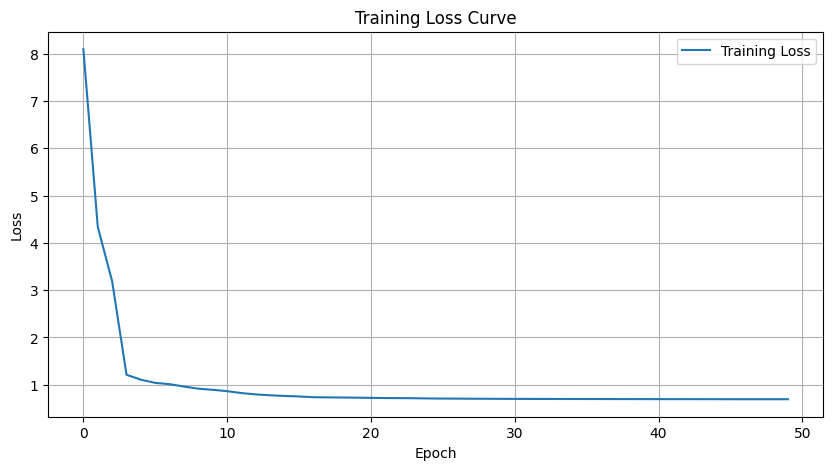

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
!pip install python-louvain

In [51]:
import community.community_louvain as community_louvain

pred = model(data.x, data.edge_index)
pred = pred.detach()

pred = (pred > 0.5).float()

G = nx.from_numpy_array(pred.numpy())
partition = community_louvain.best_partition(G)

In [52]:
def calculate_modularity(G, partition):
    communities = []
    for node, comm_id in partition.items():
        while len(communities) <= comm_id:
            communities.append([])
        communities[comm_id].append(node)

    modularity_score = community_louvain.modularity(partition, G)
    return modularity_score

In [53]:
modularity_score = calculate_modularity(G, partition)

print(f"Detected Communities Modularity: {modularity_score:.4f}")

Detected Communities Modularity: 0.0124


In [45]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [54]:
true_labels = data.y.numpy()

predicted_labels = np.array([partition[node] for node in range(len(partition))])

In [55]:
nmi_score = normalized_mutual_info_score(true_labels, predicted_labels)
ari_score = adjusted_rand_score(true_labels, predicted_labels)

print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Normalized Mutual Information (NMI): 0.0035
Adjusted Rand Index (ARI): -0.0014
